# Electricity Demand Forecsting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import joblib
from xgboost import XGBRegressor
from prophet import Prophet

In [2]:
# Load Dataset
df = pd.read_csv("final_dataset.csv")

In [3]:
# Convert Date Column
df.rename(columns={'date': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)
df.set_index('Date', inplace=True)

In [4]:
# Handle Negative Values (Scaling)
df[df < 0] = df[df < 0].abs()

In [5]:
# Selecting Features & Target Variable
features = ["min_temperature", "max_temperature", "solar_exposure", "rainfall"]
target = "demand"

In [6]:
# Scale Data
scaler = MinMaxScaler(feature_range=(0, 1))
df[features + [target]] = scaler.fit_transform(df[features + [target]])

In [7]:
# Train-Test Split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [8]:
# Prophet Model
prophet_df = df.reset_index()[["Date", target]].rename(columns={"Date": "ds", target: "y"})
prophet_model = Prophet()
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=365 * 3)
forecast = prophet_model.predict(future)

19:10:07 - cmdstanpy - INFO - Chain [1] start processing
19:10:07 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
# LSTM Model
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(df[target].values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

lstm_predictions = lstm_model.predict(X_test)

E:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0419 - val_loss: 0.0173
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0217 - val_loss: 0.0202
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0197 - val_loss: 0.0173
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0206 - val_loss: 0.0172
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0186 - val_loss: 0.0172
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0226 - val_loss: 0.0174
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0208 - val_loss: 0.0170
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0198 - val_loss: 0.0180
Epoch 9/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0191 - val_loss: 0.0192
Epoch 10/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0188 - val_loss: 0.0168
Epoch 11/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0183 - val_loss: 0.0174
Epoch 12/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 

In [10]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(train[features], train[target])
lr_predictions = lr_model.predict(test[features])

In [11]:
# XGBoost Model
xgb_model = XGBRegressor(objective="reg:squarederror")
xgb_model.fit(train[features], train[target])
xgb_predictions = xgb_model.predict(test[features])

In [12]:
# Calculate Errors
def evaluate_model(actual, predicted, model_name):
    mse = mean_squared_error(actual, predicted)
    rmse = math.sqrt(mse)
    print(f"{model_name} - MSE: {mse:.2f}, RMSE: {rmse:.2f}")
    return mse, rmse

mse_prophet, rmse_prophet = evaluate_model(test[target], forecast['yhat'][-len(test):], "Prophet")
mse_lstm, rmse_lstm = evaluate_model(y_test, lstm_predictions, "LSTM")
mse_lr, rmse_lr = evaluate_model(test[target], lr_predictions, "Linear Regression")
mse_xgb, rmse_xgb = evaluate_model(test[target], xgb_predictions, "XGBoost")

Prophet - MSE: 0.03, RMSE: 0.18
LSTM - MSE: 0.01, RMSE: 0.10
Linear Regression - MSE: 0.02, RMSE: 0.15
XGBoost - MSE: 0.02, RMSE: 0.13


In [13]:
# Best Model Selection
best_model = min([("Prophet", mse_prophet), ("LSTM", mse_lstm), ("Linear Regression", mse_lr), ("XGBoost", mse_xgb)], key=lambda x: x[1])
print(f"Best Model: {best_model[0]} with MSE: {best_model[1]:.2f}")

# Save Best Model
if best_model[0] == "Prophet":
    prophet_model.stan_backend.logger.setLevel("CRITICAL")
    joblib.dump(prophet_model, "best_model_prophet.pkl")
elif best_model[0] == "LSTM":
    lstm_model.save("best_model_lstm.h5")
elif best_model[0] == "Linear Regression":
    joblib.dump(lr_model, "best_model_lr.pkl")
else:
    joblib.dump(xgb_model, "best_model_xgb.pkl")

Best Model: LSTM with MSE: 0.01


In [14]:
# Future Forecasting
if best_model[0] == "Prophet":
    future_forecast = forecast[['ds', 'yhat']].set_index('ds')[-365*3:]
elif best_model[0] == "LSTM":
    future_input = df[target].values[-seq_length:].tolist()
    future_forecast = []
    for _ in range(365 * 3):
        pred_input = np.array(future_input[-seq_length:]).reshape(1, seq_length, 1)
        pred = lstm_model.predict(pred_input)
        future_forecast.append(pred[0][0])
        future_input.append(pred[0][0])
    future_forecast = pd.DataFrame({"ds": pd.date_range(start=df.index[-1], periods=365*3+1, freq='D')[1:], "yhat": future_forecast})
else:
    future_df = pd.DataFrame({"Date": pd.date_range(start=df.index[-1], periods=365*3+1, freq='D')[1:]})
    for col in features:
        future_df[col] = df[col].mean()
    if best_model[0] == "Linear Regression":
        future_forecast = lr_model.predict(future_df[features])
    else:
        future_forecast = xgb_model.predict(future_df[features])
    future_forecast = pd.DataFrame({"ds": future_df["Date"], "yhat": future_forecast})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━

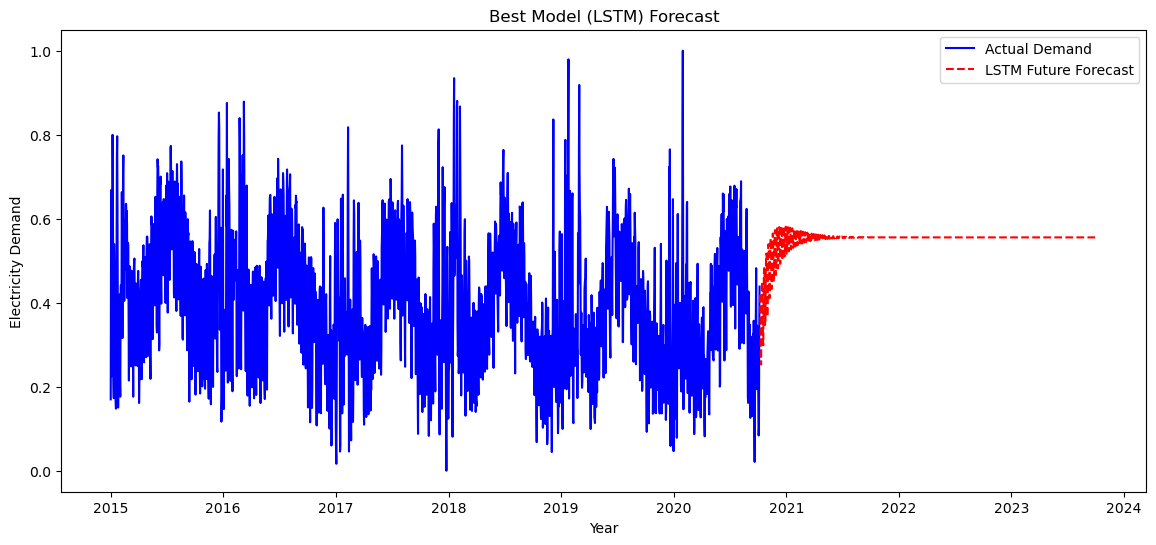

In [15]:
# Plot Forecast
plt.figure(figsize=(14, 6))
plt.plot(df.index, df[target], label="Actual Demand", color="blue")
plt.plot(future_forecast["ds"], future_forecast["yhat"], label=f"{best_model[0]} Future Forecast", color="red", linestyle='dashed')
plt.xlabel("Year")
plt.ylabel("Electricity Demand")
plt.title(f"Best Model ({best_model[0]}) Forecast")
plt.legend()
plt.show()

# Electricity Price Forecasting

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
# Load dataset
file_path = "final_dataset.csv"
df = pd.read_csv(file_path)

In [24]:
df

,Unnamed: 0.1,Unnamed: 0,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday,weekday
0,0,0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,0,1,3
1,1,1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,1,0,4
2,2,2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,0,1,5
3,3,3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,0,1,6
4,4,4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,2101,2101,2020-10-02,99585.835,-6.076028,41988.240,26.980251,57597.595,-30.173823,0.625000,12.8,26.0,22.0,0.0,1,0,4
2102,2102,2102,2020-10-03,92277.025,-1.983471,44133.510,32.438156,48143.515,-33.538025,0.583333,17.4,29.4,19.8,0.0,0,1,5
2103,2103,2103,2020-10-04,94081.565,25.008614,88580.995,26.571687,5500.570,-0.163066,0.062500,13.5,29.5,8.4,0.0,0,1,6
2104,2104,2104,2020-10-05,113610.030,36.764701,106587.375,39.616015,7022.655,-6.511550,0.083333,9.1,12.7,7.3,12.8,1,0,0


In [27]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['date'], errors='coerce')
df = df[['Date', 'RRP']]

In [30]:
df = df[['Date', 'RRP']].copy()  # Explicit copy to avoid SettingWithCopyWarning
df['RRP_scaled'] = scaler.fit_transform(df[['RRP']])

In [31]:
# Handle missing values
df.dropna(inplace=True)

In [32]:
# Scale Data (MinMaxScaler for LSTM & XGBoost)
scaler = MinMaxScaler(feature_range=(0, 1))
df['RRP_scaled'] = scaler.fit_transform(df[['RRP']])

In [33]:
# Split train-test data
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [34]:
prophet_df = train[['Date', 'RRP']].rename(columns={'Date': 'ds', 'RRP': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_df)

future = prophet_model.make_future_dataframe(periods=365*3, freq='D')
forecast_prophet = prophet_model.predict(future)

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\thota\AppData\Local\Temp\tmpn57jre6z\35ox044s.json
DEBUG:cmdstanpy:input tempfile: C:\Users\thota\AppData\Local\Temp\tmpn57jre6z\gmwg42tb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['E:\\Anaconda\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=97886', 'data', 'file=C:\\Users\\thota\\AppData\\Local\\Temp\\tmpn57jre6z\\35ox044s.json', 'init=C:\\Users\\thota\\AppData\\Local\\Temp\\tmpn57jre6z\\gmwg42tb.json', 'output', 'file=C:\\Users\\thota\\AppData\\Local\\Temp\\tmpn57jre6z\\prophet_model1f0unqua\\prophet_model-20250328105351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:53:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [

In [36]:
train_xgb, test_xgb, train_y, test_y = train_test_split(df[['RRP_scaled']], df[['RRP_scaled']], test_size=0.2, random_state=42)
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(train_xgb, train_y)
xgb_predictions = xgb_model.predict(test_xgb)

In [37]:
sequence_length = 30

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train['RRP_scaled'].values, sequence_length)
X_test, y_test = create_sequences(test['RRP_scaled'].values, sequence_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [38]:
# Build LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

lstm_predictions = lstm_model.predict(X_test)

E:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 9.0822e-04 - val_loss: 0.0011
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 2.9181e-04 - val_loss: 0.0012
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 1.8595e-04 - val_loss: 0.0012
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 5.8549e-04 - val_loss: 0.0011
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 5.5998e-04 - val_loss: 0.0011
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 2.3472e-04 - val_loss: 0.0011
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 12/100
52/52 ━━━━━━━━

In [39]:
mse_prophet = mean_squared_error(test['RRP'].values, forecast_prophet['yhat'][-len(test):])
mse_xgb = mean_squared_error(test_y, xgb_predictions)
mse_lstm = mean_squared_error(y_test, lstm_predictions)

rmse_prophet = np.sqrt(mse_prophet)
rmse_xgb = np.sqrt(mse_xgb)
rmse_lstm = np.sqrt(mse_lstm)

print(f"Prophet RMSE: {rmse_prophet}")
print(f"XGBoost RMSE: {rmse_xgb}")
print(f"LSTM RMSE: {rmse_lstm}")

# Select Best Model
best_model_name = min((rmse_prophet, "Prophet"), (rmse_xgb, "XGBoost"), (rmse_lstm, "LSTM"))[1]
print(f"Best Model: {best_model_name}")

Prophet RMSE: 180.2794063225605
XGBoost RMSE: 0.0007452925132190236
LSTM RMSE: 0.03170486585787085
Best Model: XGBoost


Dataset Columns: Index(['Unnamed: 0.1', 'Unnamed: 0', 'date', 'demand', 'RRP', 'demand_pos_RRP',
       'RRP_positive', 'demand_neg_RRP', 'RRP_negative', 'frac_at_neg_RRP',
       'min_temperature', 'max_temperature', 'solar_exposure', 'rainfall',
       'school_day', 'holiday', 'weekday'],
      dtype='object')


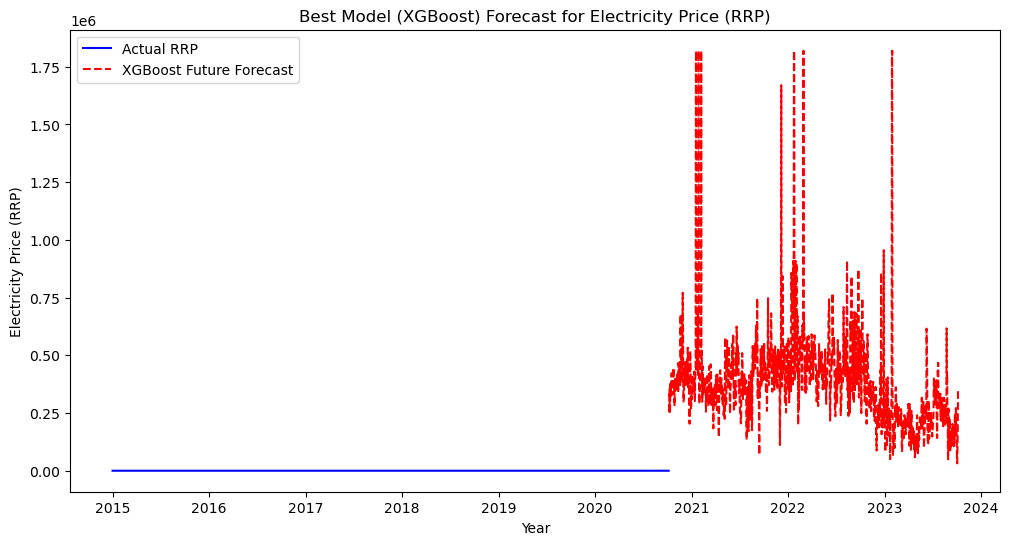

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

# Load dataset
df = pd.read_csv("final_dataset.csv")  # Replace with actual file path
df.rename(columns=lambda x: x.strip(), inplace=True)  # Strip whitespace from column names

# Check available columns
print("Dataset Columns:", df.columns)

# Ensure correct column names
if 'RRP' not in df.columns:
    raise KeyError("Column 'RRP' is missing from the dataset!")

# Use only available features
features = [col for col in ['demand', 'RRP'] if col in df.columns]

# Convert Date column to datetime format
df['date'] = pd.to_datetime(df['date'])
last_known_date = df['date'].max()

# Define future time period for forecasting
future_days = 365 * 3  # Predicting next 3 years
future_dates = pd.date_range(start=last_known_date, periods=future_days + 1, freq='D')[1:]

# Prepare Features
X_latest = df[features].values[-future_days:]  # Select last known data

# Ensure X_latest has the correct shape
if X_latest.shape[0] < future_days:
    raise ValueError("Not enough historical data to generate future predictions!")

# Scale data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[features].values)  # Scale full dataset

# Train XGBoost Model
X_train = X_scaled[:-future_days]  # Train on past data
y_train = df['RRP'].values[:-future_days]  # Target variable

xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# Predict Future Prices
X_future_scaled = scaler.transform(X_latest)  # Scale future features correctly
future_predictions = xgb_model.predict(X_future_scaled)

# Convert back to original scale (Only Rescale 'RRP')
scaler_rrp = MinMaxScaler()
df[['RRP']] = scaler_rrp.fit_transform(df[['RRP']])  # Fit only on 'RRP'
future_predictions = scaler_rrp.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot Forecast
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['RRP'], label="Actual RRP", color='blue')
plt.plot(future_dates, future_predictions, label="XGBoost Future Forecast", linestyle='dashed', color='red')
plt.legend()
plt.title("Best Model (XGBoost) Forecast for Electricity Price (RRP)")
plt.xlabel("Year")
plt.ylabel("Electricity Price (RRP)")
plt.show()